### This is part a) but with Autograd

<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html exercisesweek41.do.txt  -->
<!-- dom:TITLE: Exercises week 41 -->

In [17]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from scipy.special import lmbda
import seaborn as sns

#Design matrix kode -> samme som Nadia
def Design(x,degree):
    X = np.zeros((len(x[:,0]),degree+1))
    for i in range(degree+1):
        X[:,i] = x[:,0]**i
    return X


def MSE(z,zpred): #z=target data, zpred=predicted target data
    return np.mean((z-zpred)**2)


def R2(z,zpred):
    return 1 - np.sum((z - zpred)**2) / np.sum((z - np.mean(z)) ** 2)

#AUTOGRAD 
#Similar to week 39: Using Autograd with OLS
def CostOLS(beta, X, y, n):
    return (1.0 / n) * np.sum((y - X @ beta) ** 2)

def CostRidge(beta, X, y, n, lmbda):
    return (1.0 / n) * np.sum((y - X @ beta) ** 2) + lmbda * np.sum(beta ** 2)

# Gradient functions using Autograd
def gradientOLS(X, y, beta, n):
    cost = lambda b: CostOLS(b, X, y, n)
    return grad(cost)(beta)

def gradientRidge(X, y, beta, n, lmbda):
    cost = lambda b: CostRidge(b, X, y, n, lmbda)
    return grad(cost)(beta)



#### Task 1 Plain GD

In [18]:
# Gradient Descent
def GD (X, y, beta, n = 100, eta = 0.001, ridge = False, momentum = False,  delta_momentum = 0.3, change = 0.0, lmbda = 0.01, Niterations = 100):
    #Momemtum code taken from Week 39: Same code but now with momentum gradient descent
    for iter in range(Niterations):
        if ridge == False: #lin reg
            gradient = gradientOLS(X, y, beta, n)
        elif ridge == True:
            gradient = gradientRidge(X, y, beta, n, lmbda)

        if momentum:
            new_change = eta * gradient + delta_momentum * change
            beta -= new_change
            change = new_change
        else:
            beta -= eta * gradient

    return beta


In [19]:

# Plotting cost functions with different learning rates
def plot_GD_with_learning_rates(X, y, beta, niterations, learning_rates, ridge=False, lmbda=0.01):
    # Prepare the plot
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    # Run gradient descent for each learning rate and plot results
    for idx, eta in enumerate(learning_rates):
        # Perform gradient descent
        beta_gd = GD(X, y, beta.copy(), eta=eta, ridge=ridge, lmbda=lmbda, Niterations=niterations)
        ypred = X @ beta_gd  # Predicted values

        # Select the appropriate subplot
        ax_idx = (idx // 2, idx % 2)
        ax[ax_idx].plot(X[:, 1], ypred, 'ro', label='Plain GD')
        ax[ax_idx].plot(X[:, 1], y, 'bo', label='Data')
        ax[ax_idx].set_xlabel(r'$x$')
        ax[ax_idx].set_ylabel(r'$y$')
        mse = MSE(y, ypred)
        r2 = R2(y, ypred)
        ax[ax_idx].set_title(f'Eta = {eta} (MSE = {round(mse, 4)}) (R2 = {round(r2, 4)})')
        ax[ax_idx].legend()

    # Adjust layout
    fig.suptitle('Gradient Descent for OLS with Various Learning Rates', fontsize=20)
    plt.tight_layout()
    plt.show()


#seaborn plotting funtion -> for ridge
def plotHeatmapGDRidge(X, y, beta, lr, lmbda, niterations=500):
    """
    Creates two heatmaps, one for MSE and one for R2, using gradient descent 
    with Ridge regression for different learning rates and regularization parameters.
    """
    # Initialize arrays for storing MSE and R2 scores
    mse = np.zeros((len(lr), len(lmbda)))
    r2 = np.zeros((len(lr), len(lmbda)))

    # Calculate MSE and R2 for each combination of learning rate and lambda
    for i in range(len(lr)):
        for j in range(len(lmbda)):
            # Perform gradient descent with Ridge regression
            beta_gd = GD(X, y, beta.copy(), eta=lr[i], lmbda=lmbda[j], ridge=True, Niterations=niterations)
            y_gd = X @ beta_gd  # Predicted values

            # Calculate MSE and R2
            mse[i, j] = MSE(y, y_gd)
            r2[i, j] = R2(y, y_gd)

    # Set up tick labels based on learning rates and lambda values
    xticks = [f"$10^{{{int(np.log10(val))}}}$" for val in lmbda]
    yticks = [f"$10^{{{int(np.log10(val))}}}$" for val in lr]

    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 11))

    # Plot MSE heatmap
    heatmap_mse = sns.heatmap(mse, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks,
                              vmin=0, annot_kws={"fontsize": 22}, ax=ax1)
    cbar_mse = heatmap_mse.collections[0].colorbar
    cbar_mse.ax.tick_params(labelsize=19)  # Adjust font size of colorbar ticks
    cbar_mse.set_label('MSE', fontsize=19)

    # Axis labels and title for MSE heatmap
    ax1.tick_params(left=False, bottom=False)
    ax1.set_title("MSE for Gradient Descent with Ridge Regression", fontsize=20)
    ax1.set_ylabel("$\eta$ (Learning Rate)", fontsize=19)
    ax1.set_xlabel("$\lambda$ (Regularization Parameter)", fontsize=19)
    ax1.tick_params(axis='both', which='major', labelsize=19)

    # Plot R2 heatmap
    heatmap_r2 = sns.heatmap(r2, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks,
                             vmax=1, annot_kws={"fontsize": 22}, ax=ax2)
    cbar_r2 = heatmap_r2.collections[0].colorbar
    cbar_r2.ax.tick_params(labelsize=19)  # Adjust font size of colorbar ticks
    cbar_r2.set_label("$R^2$", fontsize=19)

    # Axis labels and title for R2 heatmap
    ax2.tick_params(left=False, bottom=False)
    ax2.set_title("R² Score for Gradient Descent with Ridge Regression", fontsize=20)
    ax2.set_ylabel("$\eta$ (Learning Rate)", fontsize=19)
    ax2.set_xlabel("$\lambda$ (Regularization Parameter)", fontsize=19)
    ax2.tick_params(axis='both', which='major', labelsize=19)

    plt.tight_layout()
    plt.show()



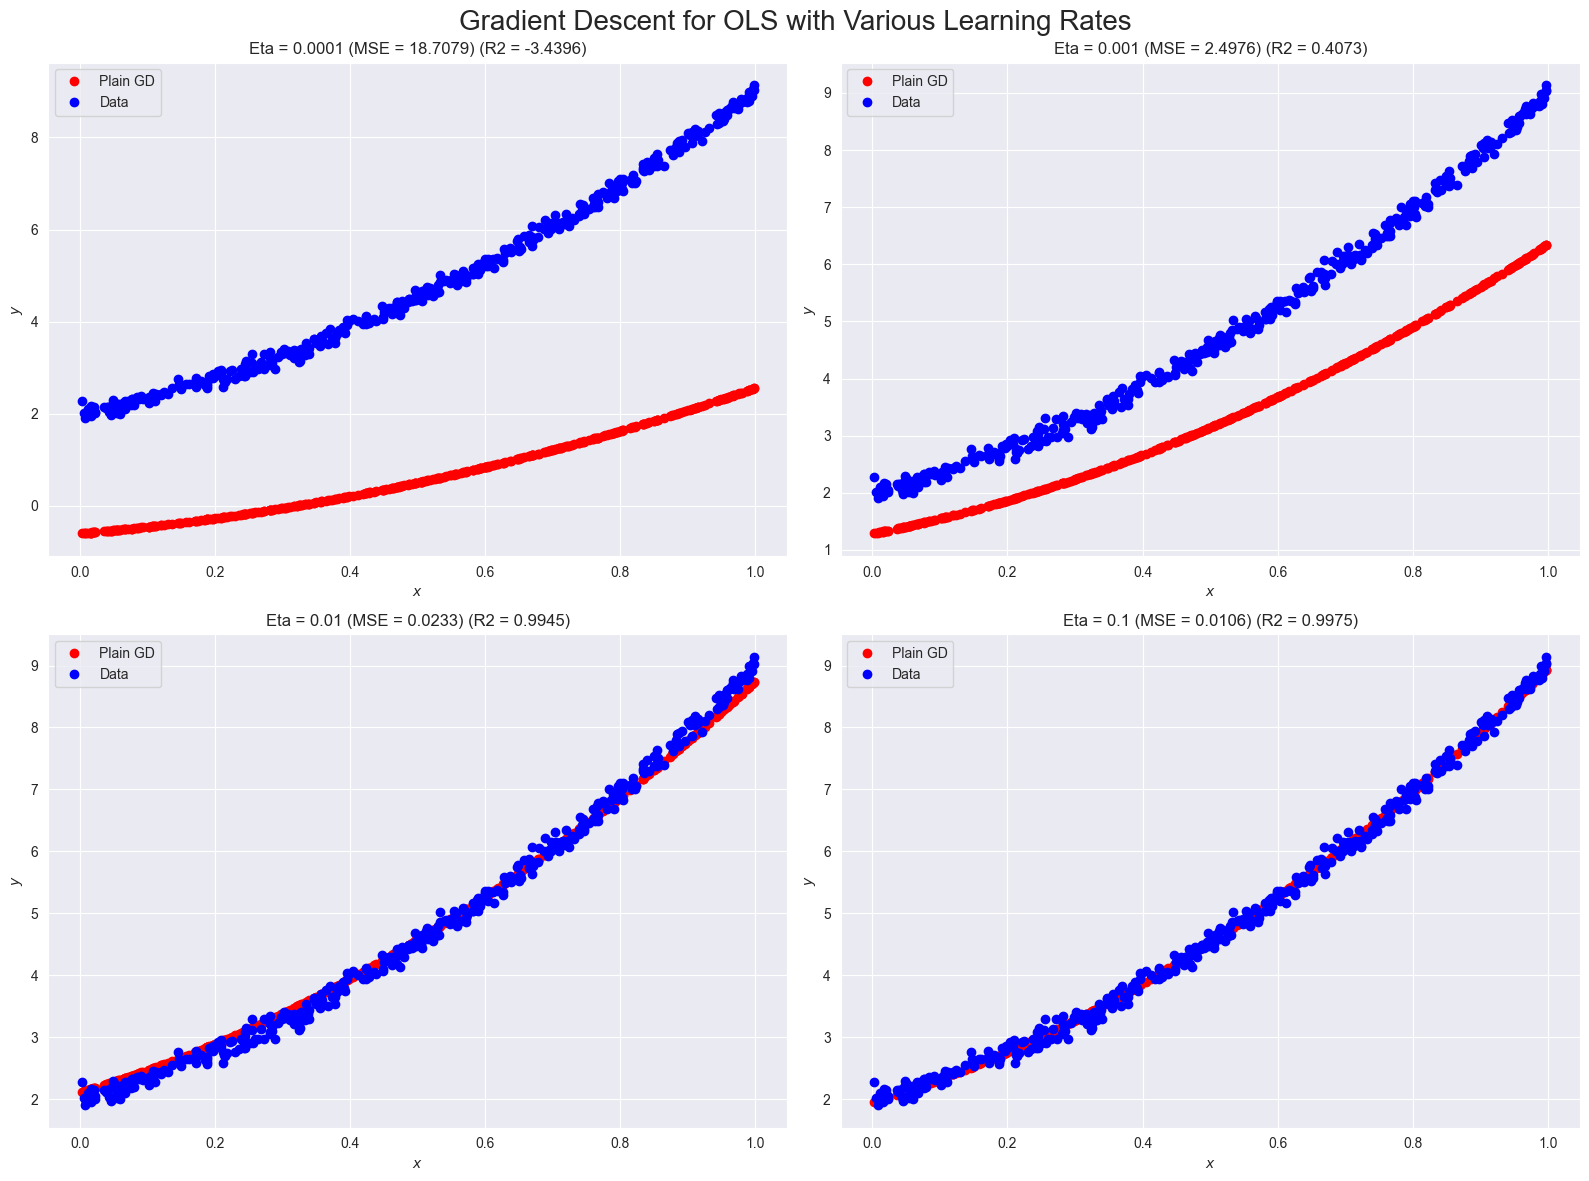

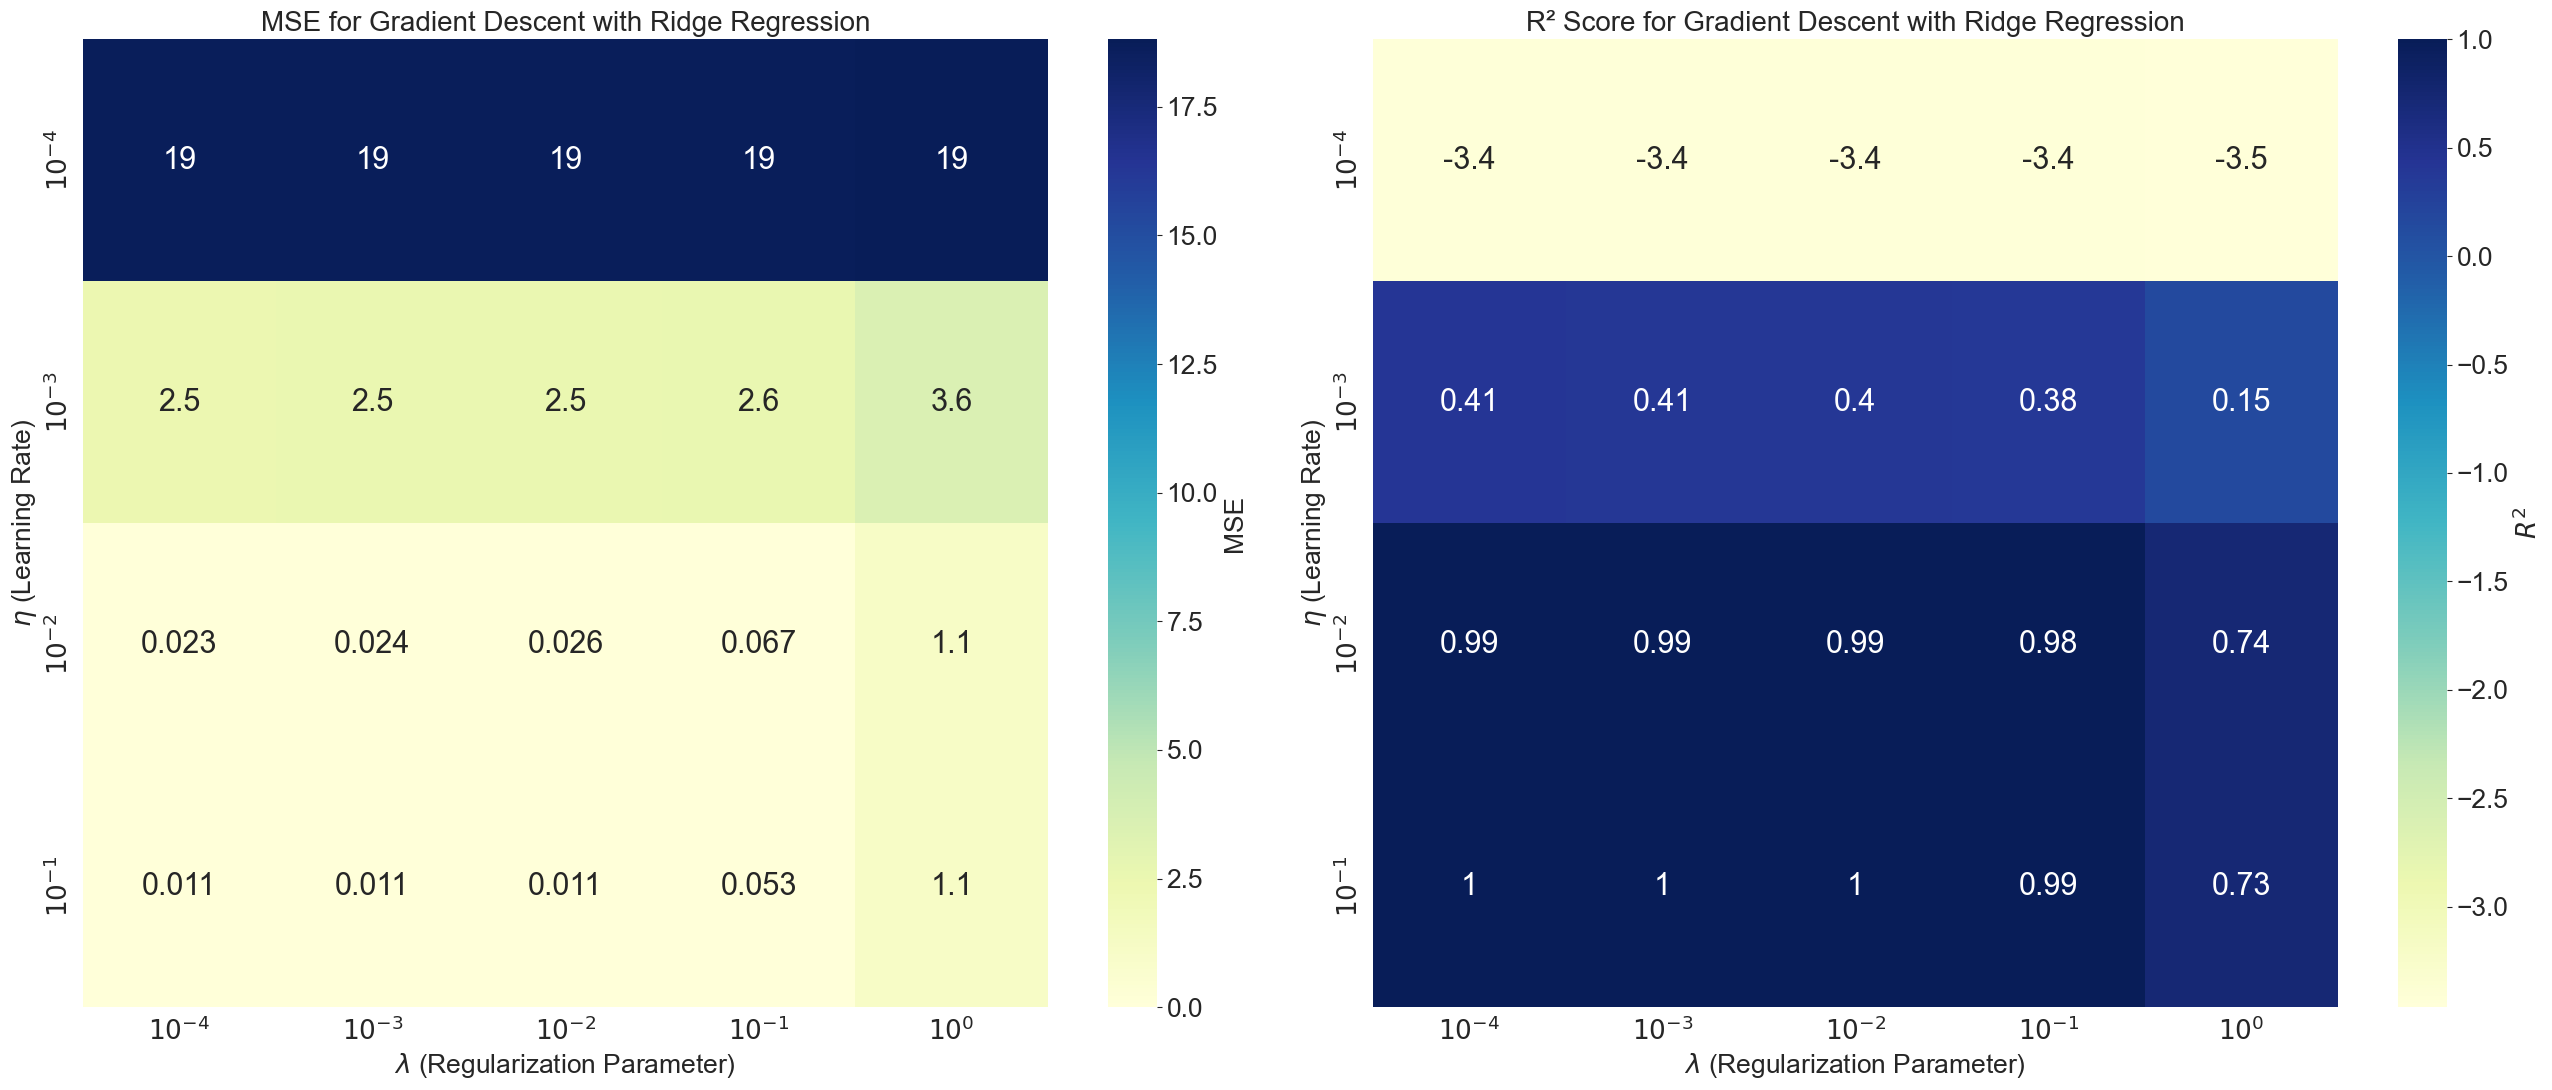

In [20]:
# Modifies the example taken  from week 39: Gradient Descent Example
np.random.seed(2014)
# Generate some data
n = 400
x = np.random.rand(n,1) #input
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n,1) #4x^2 + 3x + 2 + noise
p = 2 #polynomial degree 

X = Design(x,p) #design matrix
beta = np.random.randn(p+1,1) #initialize parameters

#same as project 1
learning_rates = np.logspace(-4, -1, 4)#learning rates
lambdas = np.logspace(-4, 0, 5)# lambdas

plot_GD_with_learning_rates(X, y, beta, niterations=100, learning_rates=learning_rates)
plotHeatmapGDRidge(X, y, beta, learning_rates, lambdas, niterations=100)




#### Discussion:
In these plots we can see that the learning rate of 0.1 is the one closest to the reference line. When i was testing with higher number of iterations, the lower learning rates also was closer to the reference line. 

The ridge regression is not as good as the OLS, but it is still close to the reference line. 

### Step 2: Gradient Descent with Momentum
Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Keep using the analytical expression for the gradient.

In [21]:
def plot_OLS_convergence(X, y, beta, eta, Niterations=100, momentum=0.2, change=0.01):
    # Lists to track MSE for each method over iterations
    plain_OLS, momentum_OLS = [], []

    for n in range(1, Niterations + 1):
        # Compute beta values for each method
        beta_plain_OLS = GD(X, y, beta.copy(), eta=eta, ridge=False, momentum=False, Niterations=n)
        beta_momentum_OLS = GD(X, y, beta.copy(), eta=eta, ridge=False, momentum=True, delta_momentum=momentum, change=change, Niterations=n)

        # Calculate predictions and MSE
        plain_OLS.append(MSE(y, X @ beta_plain_OLS))
        momentum_OLS.append(MSE(y, X @ beta_momentum_OLS))

    # Plotting convergence of OLS
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Niterations + 1), plain_OLS, 'r', label=f'Plain GD (eta={eta})')
    plt.plot(range(1, Niterations + 1), momentum_OLS, 'b', label=f'Momentum GD (eta={eta}, mtm={momentum})')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    plt.title('OLS Convergence')
    plt.legend()
    plt.yscale("log")  # Log scale for better visualization
    plt.show()
    
#Ridge heat map -> usikker her
def plot_Ridge_heatmaps_momentum(X, y, beta, learning_rates, lambdas, Niterations=100, delta_momentum=0.5, change=0.00):
    # Initialize arrays to store MSE values for both cases
    mse_plain = np.zeros((len(learning_rates), len(lambdas)))
    mse_momentum = np.zeros((len(learning_rates), len(lambdas)))

    # Calculate MSE for each combination of learning rate and lambda, with and without momentum
    for i, eta in enumerate(learning_rates):
        for j, lmbda in enumerate(lambdas):
            # Plain GD with Ridge
            beta_plain = GD(X, y, beta.copy(), eta=eta, lmbda=lmbda, ridge=True, momentum=False, Niterations=Niterations)
            y_pred_plain = X @ beta_plain
            mse_plain[i, j] = MSE(y, y_pred_plain)

            # GD with Momentum
            beta_momentum = GD(X, y, beta.copy(), eta=eta, lmbda=lmbda, ridge=True, momentum=True, delta_momentum=delta_momentum, change=change, Niterations=Niterations)
            y_pred_momentum = X @ beta_momentum
            mse_momentum[i, j] = MSE(y, y_pred_momentum)

    # Set up tick labels
    xticks = [f"$10^{{{int(np.log10(val))}}}$" for val in lambdas]
    yticks = [f"$10^{{{int(np.log10(val))}}}$" for val in learning_rates]

    # Plot side-by-side heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

    # Heatmap for Plain GD
    sns.heatmap(mse_plain, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12}, ax=ax1)
    ax1.set_xlabel("$\lambda$ (Regularization Parameter)")
    ax1.set_ylabel("$\eta$ (Learning Rate)")
    ax1.set_title("MSE for Ridge Regression (Plain GD)")

    # Heatmap for GD with Momentum
    sns.heatmap(mse_momentum, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12}, ax=ax2)
    ax2.set_xlabel("$\lambda$ (Regularization Parameter)")
    ax2.set_ylabel("$\eta$ (Learning Rate)")
    ax2.set_title("MSE for Ridge Regression (GD with Momentum)")

    plt.show()

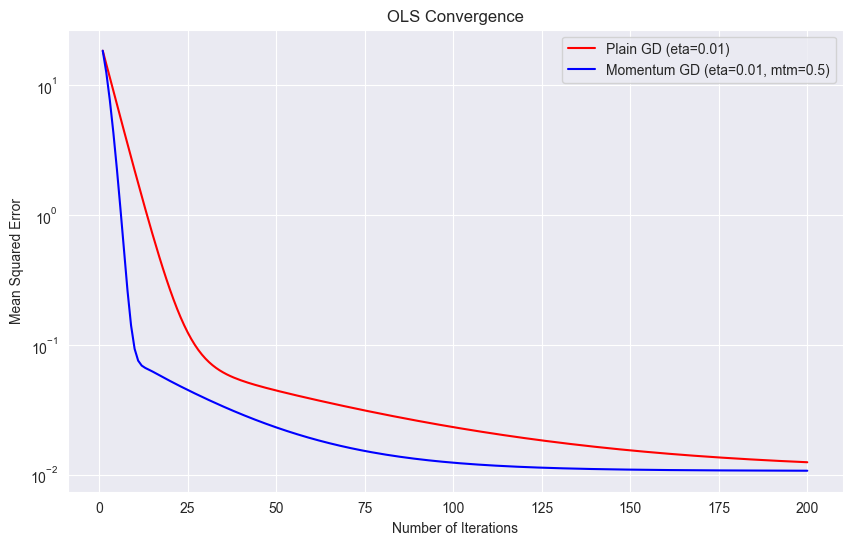

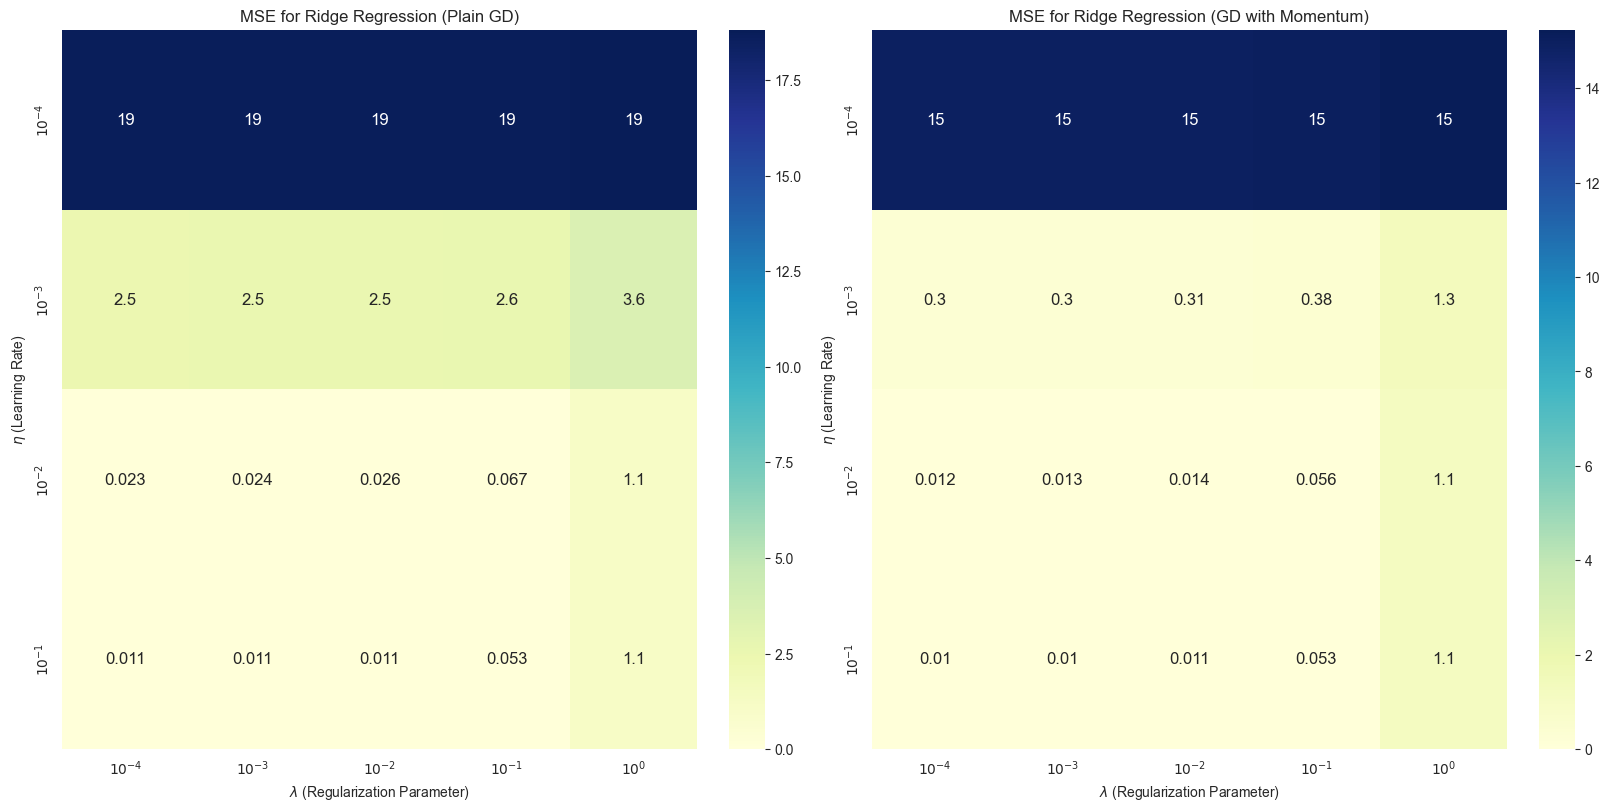

In [22]:
# Modifies the example taken  from week 39: Gradient Descent Example
np.random.seed(2014)
# Generate some data
n = 400
x = np.random.rand(n,1) #input
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n,1) #4x^2 + 3x + 2 + noise
p = 2 #polynomial degree 

X = Design(x,p) #design matrix
beta = np.random.randn(p+1,1) #initialize parameters

#same as project 1
learning_rates = np.logspace(-4, -1, 4)#learning rates
lambdas = np.logspace(-4, 0, 5)# lambdas

eta = 0.01
Niterations = 200
momentum = 0.5
change = 0.00

plot_OLS_convergence(X, y, beta, eta, Niterations, momentum, change)

plot_Ridge_heatmaps_momentum(X, y, beta, learning_rates, lambdas, Niterations=100)


#### Discussion:
We can see that the gradient descent with momentum converges faster than the plain gradient descent.


### Step 3: Stochastic Gradient Descent (SGD) with Mini-batches

In [23]:
#Code taken and modified from week 39: Code with a Number of Minibatches which varies, analytical gradient
def learning_schedule(t, t0=5, t1=50):
    return t0/(t+t1)

#Code taken and modified from week 39: Code with a Number of Minibatches which varies, analytical gradient
#SGD with momentum and ridge + Fiks
def SGD(X, y, beta, n = 100, n_epochs=50, batch_size=5, momentum=0.5, change=0.1, ridge=False, lmbda=0.01, t0 =5, t1 = 50):
    M = batch_size
    m = int(n / M)  # Number of mini-batches
    for epoch in range(n_epochs):
        for i in range(m):
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]

            if ridge:
                gradient = gradientRidge(xi, yi, beta, n, lmbda)
            else:
                gradient = gradientOLS(xi, yi, beta, n)



            eta = learning_schedule(epoch * m + i, t0, t1)
            new_change = eta * gradient + momentum * change
            beta -= new_change
            change = new_change

    return beta


In [24]:
## SGD VS GD
def plot_OLS_convergence_GD_vs_SGD(X, y, beta, eta, Niterations=100, batch_size=5, momentum=0.8, change=0.1):
    # Initialize lists to track MSE for both methods over iterations
    mse_GD, mse_SGD = [], []
    beta_GD = beta.copy()
    beta_SGD = beta.copy()

    # Perform GD
    for n in range(1, Niterations + 1):
        beta_GD = GD(X, y, beta_GD.copy(), eta=eta, ridge=False, momentum=True, delta_momentum=momentum, change=change, Niterations=n)
        mse_GD.append(MSE(y, X @ beta_GD))

    # Perform SGD
    for n in range(1, Niterations + 1):
        beta_SGD = SGD(X, y, beta_SGD.copy(), n=len(y), n_epochs=n, batch_size=batch_size, momentum=momentum, change=change, ridge=False)
        mse_SGD.append(MSE(y, X @ beta_SGD))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Niterations + 1), mse_GD, 'r', label=f'GD with Momentum (eta={eta})')
    plt.plot(range(1, Niterations + 1), mse_SGD, 'b', label=f'SGD with Momentum (batch size={batch_size})')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    plt.title('OLS Convergence: GD vs SGD with Momentum')
    plt.legend()
    plt.yscale("log")  # Log scale for better visualization
    plt.show()


def plot_Ridge_heatmap_GD_vs_SGD(X, y, beta, learning_rates, lambdas, Niterations=100, batch_size=5, momentum=0.8, change=0.1):
    # Initialize arrays to store MSE for each combination of eta and lambda
    mse_GD = np.zeros((len(learning_rates), len(lambdas)))
    mse_SGD = np.zeros((len(learning_rates), len(lambdas)))

    # Calculate MSE for each combination of learning rate and lambda, with momentum enabled
    for i, eta in enumerate(learning_rates):
        for j, lmbda in enumerate(lambdas):
            # GD with Ridge
            beta_GD = GD(X, y, beta.copy(), eta=eta, lmbda=lmbda, ridge=True, momentum=True, delta_momentum=momentum, change=change, Niterations=Niterations)
            mse_GD[i, j] = MSE(y, X @ beta_GD)

            # SGD with Ridge
            beta_SGD = SGD(X, y, beta.copy(), n=len(y), n_epochs=Niterations, batch_size=batch_size, momentum=momentum, change=change, ridge=True, lmbda=lmbda)
            mse_SGD[i, j] = MSE(y, X @ beta_SGD)

    # Set up tick labels
    xticks = [f"$10^{{{int(np.log10(val))}}}$" for val in lambdas]
    yticks = [f"$10^{{{int(np.log10(val))}}}$" for val in learning_rates]

    # Plot side-by-side heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

    # Heatmap for GD with Momentum
    sns.heatmap(mse_GD, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12}, ax=ax1)
    ax1.set_xlabel("$\lambda$ (Regularization Parameter)")
    ax1.set_ylabel("$\eta$ (Learning Rate)")
    ax1.set_title("MSE for Ridge Regression (GD with Momentum)")

    # Heatmap for SGD with Momentum
    sns.heatmap(mse_SGD, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12}, ax=ax2)
    ax2.set_xlabel("$\lambda$ (Regularization Parameter)")
    ax2.set_ylabel("$\eta$ (Learning Rate)")
    ax2.set_title("MSE for Ridge Regression (SGD with Momentum)")

    plt.show()




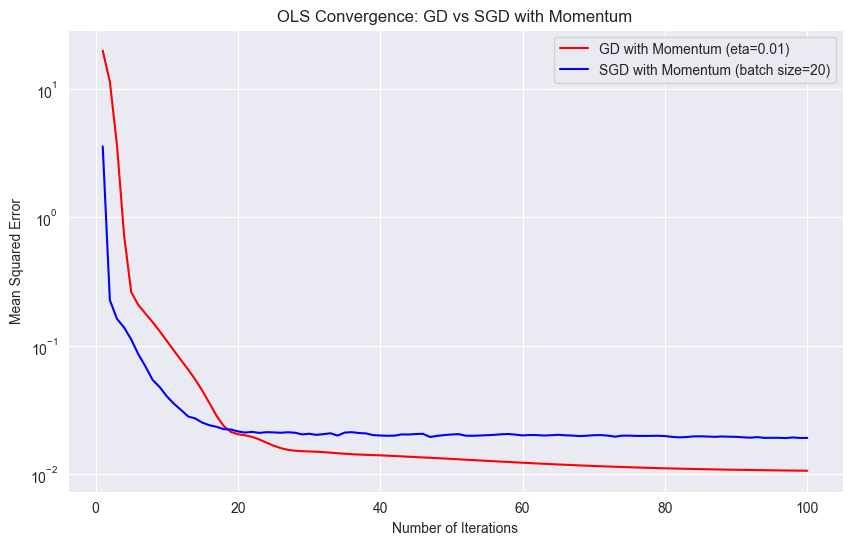

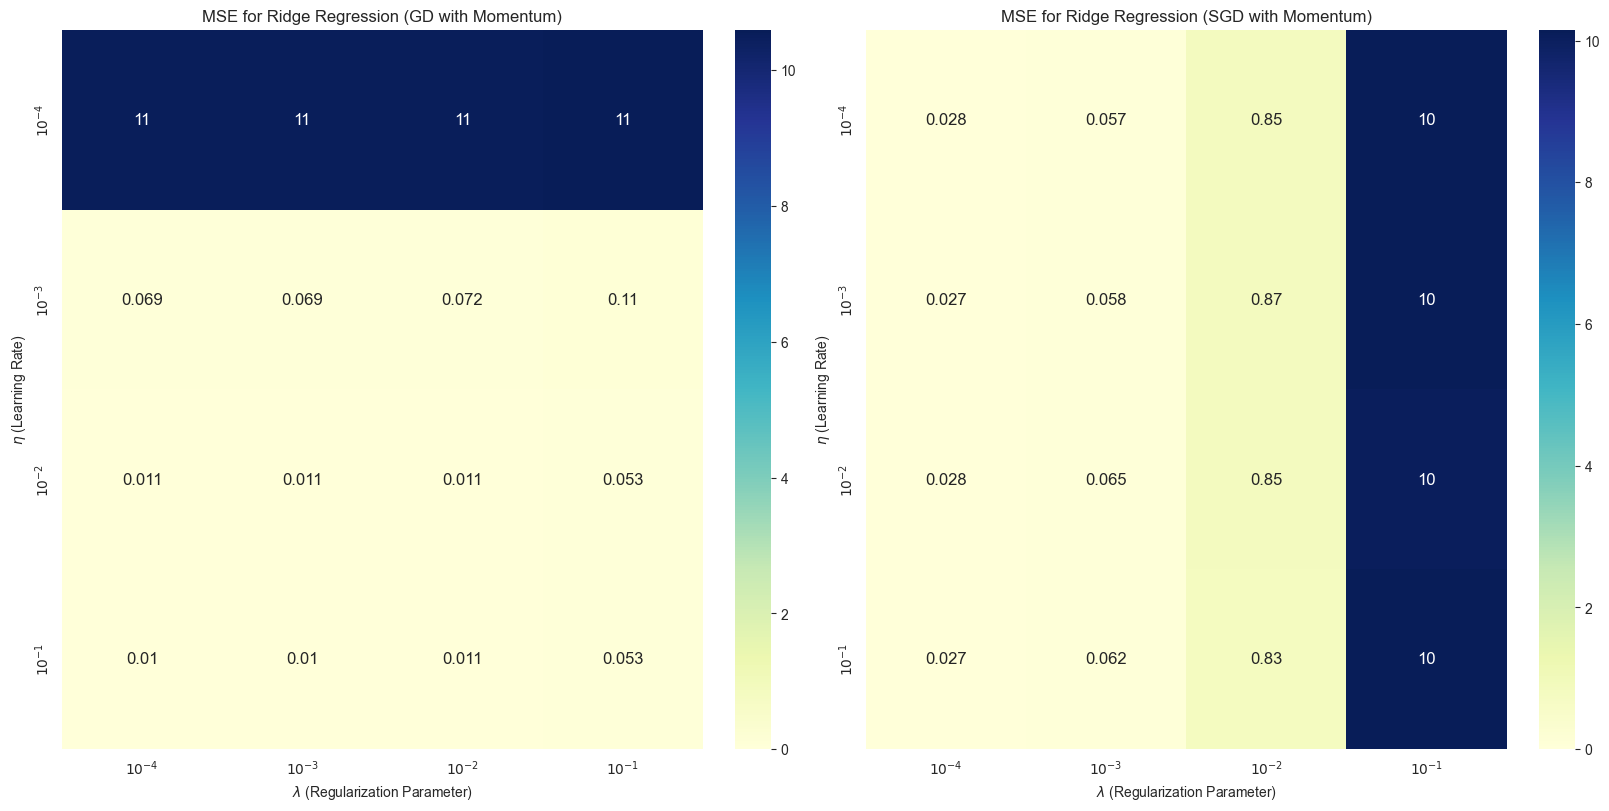

In [25]:
# Modifies the example taken  from week 39: Gradient Descent Example
np.random.seed(2014)
# Generate some data
n = 400
x = np.random.rand(n,1) #input
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n,1) #4x^2 + 3x + 2 + noise
p = 2 #polynomial degree 

X = Design(x,p) #design matrix
beta = np.random.randn(p+1,1) #initialize parameters

#same as project 1
learning_rates = np.logspace(-4, -1, 4)#learning rates
lambdas = np.logspace(-4, 0, 5)# lambdas

# Parameters
eta = 0.01
Niterations = 100
batch_size = 20

plot_OLS_convergence_GD_vs_SGD(X, y, beta, eta, Niterations, batch_size)

# Example usage for Ridge Regression heatmaps
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
lambdas = [1e-4, 1e-3, 1e-2, 1e-1]

plot_Ridge_heatmap_GD_vs_SGD(X, y, beta, learning_rates, lambdas, Niterations, batch_size)


Overall, the plots align well with typical expectations for GD and SGD with momentum:

SGD converges faster in terms of iterations and can reach a stable low MSE early on.
GD converges more gradually, with MSE depending heavily on the learning rate.
The heatmaps for Ridge regression reveal that both methods perform best with moderate learning rates and show expected behavior with increasing regularization strength (λ).

In [26]:
##Batch sizes
def plot_OLS_convergence_SGD_batch_sizes(X, y, beta, eta=0.01, n_epochs=100, batch_sizes=[5, 10, 20], t0=5, t1=50, momentum=0.8, change=0.1):
    n = len(y)
    mse_per_batch_size = np.zeros((len(batch_sizes), n_epochs))  # Matrix to store MSE for each batch size

    for idx, batch_size in enumerate(batch_sizes):
        for epoch in range(1, n_epochs + 1):
            # Perform SGD for each epoch
            beta_SGD = SGD(X, y, beta.copy(), n=n, n_epochs=epoch, batch_size=batch_size, momentum=momentum, change=change, ridge=False, lmbda=0.01, t0=t0, t1=t1)
            mse_per_batch_size[idx, epoch - 1] = MSE(y, X @ beta_SGD)  # Store MSE after each epoch

    # Plotting convergence for each batch size
    plt.figure(figsize=(10, 6))
    for idx, batch_size in enumerate(batch_sizes):
        plt.plot(range(1, n_epochs + 1), mse_per_batch_size[idx, :], label=f'SGD (eta={eta}, batch_size={batch_size})')

    plt.xlabel('Number of Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('OLS Convergence: Effect of Mini-Batch Size in SGD')
    plt.legend()
    plt.ylim(0, 0.25)
    plt.show()
    
def plot_Ridge_heatmap_SGD_batch_sizes(X, y, beta, eta, batch_sizes, lambdas, n_epochs=50, t0=5, t1=50, momentum=0.8, change=0.1):
    # Initialize arrays to store MSE values for each batch size and lambda combination
    mse_values = np.zeros((len(batch_sizes), len(lambdas)))
    n = len(y)

    # Calculate MSE for each combination of batch size and lambda
    for i, batch_size in enumerate(batch_sizes):
        for j, lmbda in enumerate(lambdas):
            # Perform SGD with Ridge regression over multiple epochs
            beta_SGD = SGD(X, y, beta.copy(), n=n, n_epochs=n_epochs, batch_size=batch_size, ridge=True, lmbda=lmbda, t0=t0, t1=t1, momentum=momentum, change=change)
            y_pred_SGD = X @ beta_SGD
            mse_values[i, j] = MSE(y, y_pred_SGD)

    # Set up tick labels for heatmap
    xticks = [f"$10^{{{int(np.log10(val))}}}$" for val in lambdas]
    yticks = [str(batch_size) for batch_size in batch_sizes]

    # Plotting the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(mse_values, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12})
    plt.xlabel("$\lambda$ (Regularization Parameter)")
    plt.ylabel("Mini-Batch Size")
    plt.title("MSE for Ridge Regression: Effect of Mini-Batch Size in SGD")
    plt.show()



In [ ]:

np.random.seed(2014)
n = 400
x = np.random.rand(n,1)  # Input
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n,1)  # Target with noise
p = 2  # Polynomial degree
X = Design(x, p)  # Design matrix
beta = np.random.randn(p + 1, 1)  # Initialize parameters
batch_sizes = [1, 5, 10, 50, 75, 100]  # Batch sizes to test

plot_OLS_convergence_SGD_batch_sizes(X, y, beta, eta=0.01, n_epochs=100, batch_sizes=batch_sizes, t0=5, t1=50, momentum=0.8, change=0.1)

batch_sizes = [5, 10, 20, 50]  # Different batch sizes to test
lambdas = [1e-4, 1e-3, 1e-2, 1e-1]  # Regularization parameters to test

plot_Ridge_heatmap_SGD_batch_sizes(X, y, beta, eta=0.01, batch_sizes=batch_sizes, lambdas=lambdas, n_epochs=50, t0=5, t1=50, momentum=0.8, change=0.1)



### Disussion of Results
 For both OLS and Ridge regression, using smaller batch sizes results in faster convergence due to more frequent updates, though these updates tend to be noisier.

We can also see that ridge regression generally has more stable updates. This is due to regularization.

OLS Convergence Plot: Shows faster stabilization for larger batch sizes but quick convergence for all sizes due to the nature of the OLS problem.
Ridge Regression Heatmap: Reveals the interaction between mini-batch size and regularization strength, with larger 
λ values leading to higher MSE and larger batch sizes providing smoother results.



### Step 4: Adagrad
Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.

In [1]:

def AdagradGD(X, y, beta, n = 100, eta = 0.001, lmbda = 0.01, Niterations = 100, ridge = False, momentum = False,  delta_momentum = 0.3, delta=1e-8):
    change = 0.0
    Giter=0.0
    
    for iter in range(Niterations):
        if ridge == False:
            gradient = gradientOLS(X, y, beta, n)
        else:
            gradient = gradientRidge(X, y, beta, n, lmbda)

        Giter += gradient**2
        update = eta * gradient / (delta + np.sqrt(Giter))

        if momentum:
            new_change = update + delta_momentum * change
            beta -= new_change
            change = new_change
        else:
            beta -= update

    return beta

#with mini batches
def Adagrad_SGD(X, y, beta, n = 100, n_epochs=50, batch_size=5, eta=0.01, ridge = False, lmbda = 0.01, momentum = False,  delta_momentum=0.3, delta=1e-8):
    M = batch_size
    m = int(n / M)
    change = 0.0
    Giter=0.0

    for epoch in range(n_epochs):
        for i in range(m):
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]

            if ridge:
                gradients = gradientRidge(xi, yi, beta, n, lmbda)
            else:
                gradients = gradientOLS(xi, yi, beta, n)

            Giter += gradients**2
            update = eta * gradients / (delta + np.sqrt(Giter))

            if momentum:
                new_change = update + delta_momentum * change
                beta -= new_change
                change = new_change
            else:
                beta -= update

    return beta



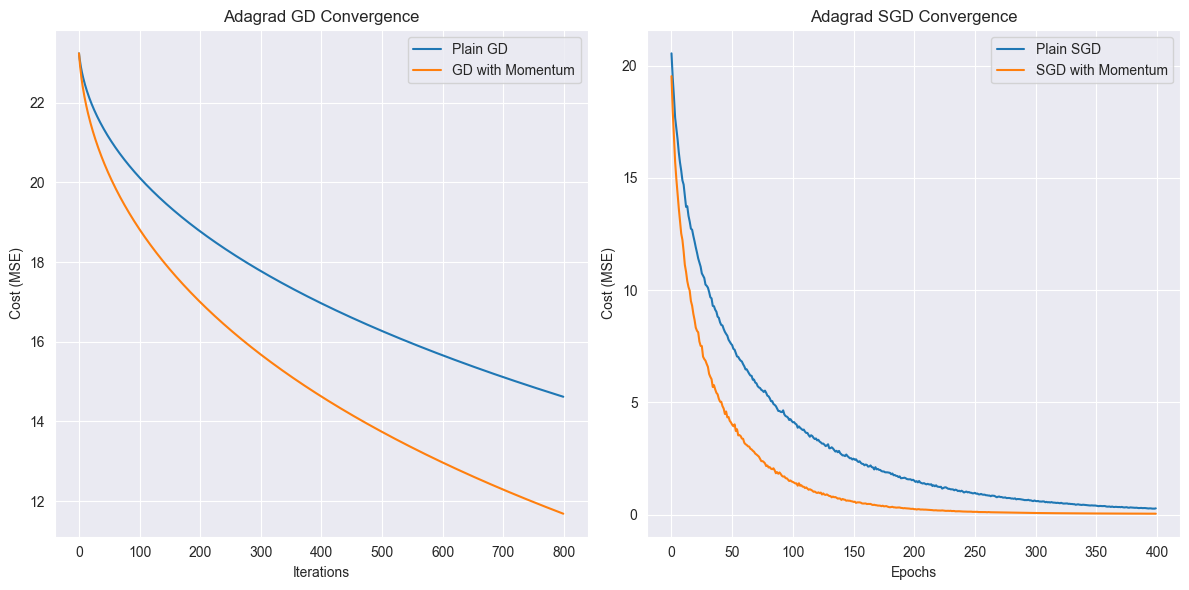

In [19]:
def plot_convergence(X, y, beta, n, eta, Niterations, n_epochs, batch_size, delta_momentum):
    # Arrays to store costs for comparison
    costs_plain_GD = []
    costs_GD_momentum = []
    costs_plain_SGD = []
    costs_SGD_momentum = []

    max_iterations = max(Niterations, n_epochs)

    for i in range(max_iterations):
        if i < Niterations:
            beta_plain_GD = AdagradGD(X, y, beta.copy(), n, eta, Niterations=i+1, momentum=False)
            beta_GD_momentum = AdagradGD(X, y, beta.copy(), n, eta, Niterations=i+1, momentum=True, delta_momentum=delta_momentum)
            costs_plain_GD.append(np.mean((y - X @ beta_plain_GD)**2))
            costs_GD_momentum.append(np.mean((y - X @ beta_GD_momentum)**2))

        if i < n_epochs:
            beta_plain_SGD = Adagrad_SGD(X, y, beta.copy(), n, n_epochs=i+1, batch_size=batch_size, eta=eta, momentum=False)
            beta_SGD_momentum = Adagrad_SGD(X, y, beta.copy(), n, n_epochs=i+1, batch_size=batch_size, eta=eta, momentum=True, delta_momentum=delta_momentum)
            costs_plain_SGD.append(np.mean((y - X @ beta_plain_SGD)**2))
            costs_SGD_momentum.append(np.mean((y - X @ beta_SGD_momentum)**2))

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(costs_plain_GD, label="Plain GD")
    plt.plot(costs_GD_momentum, label="GD with Momentum")
    plt.xlabel("Iterations")
    plt.ylabel("Cost (MSE)")
    plt.title("Adagrad GD Convergence")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(costs_plain_SGD, label="Plain SGD")
    plt.plot(costs_SGD_momentum, label="SGD with Momentum")
    plt.xlabel("Epochs")
    plt.ylabel("Cost (MSE)")
    plt.title("Adagrad SGD Convergence")
    plt.legend()

    plt.tight_layout()
    plt.show()



np.random.seed(2014)
n = 400
x = np.random.rand(n, 1)  # Input
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n, 1)  # Target with noise
p = 2  # Polynomial degree
X = Design(x, p)  # Design matrix
beta = np.random.randn(p + 1, 1)  # Initialize parameters
eta = 0.01
Niterations = 800
n_epochs = 400
batch_size = 5
delta_momentum = 0.3

plot_convergence(X, y, beta, n, eta, Niterations, n_epochs, batch_size, delta_momentum)

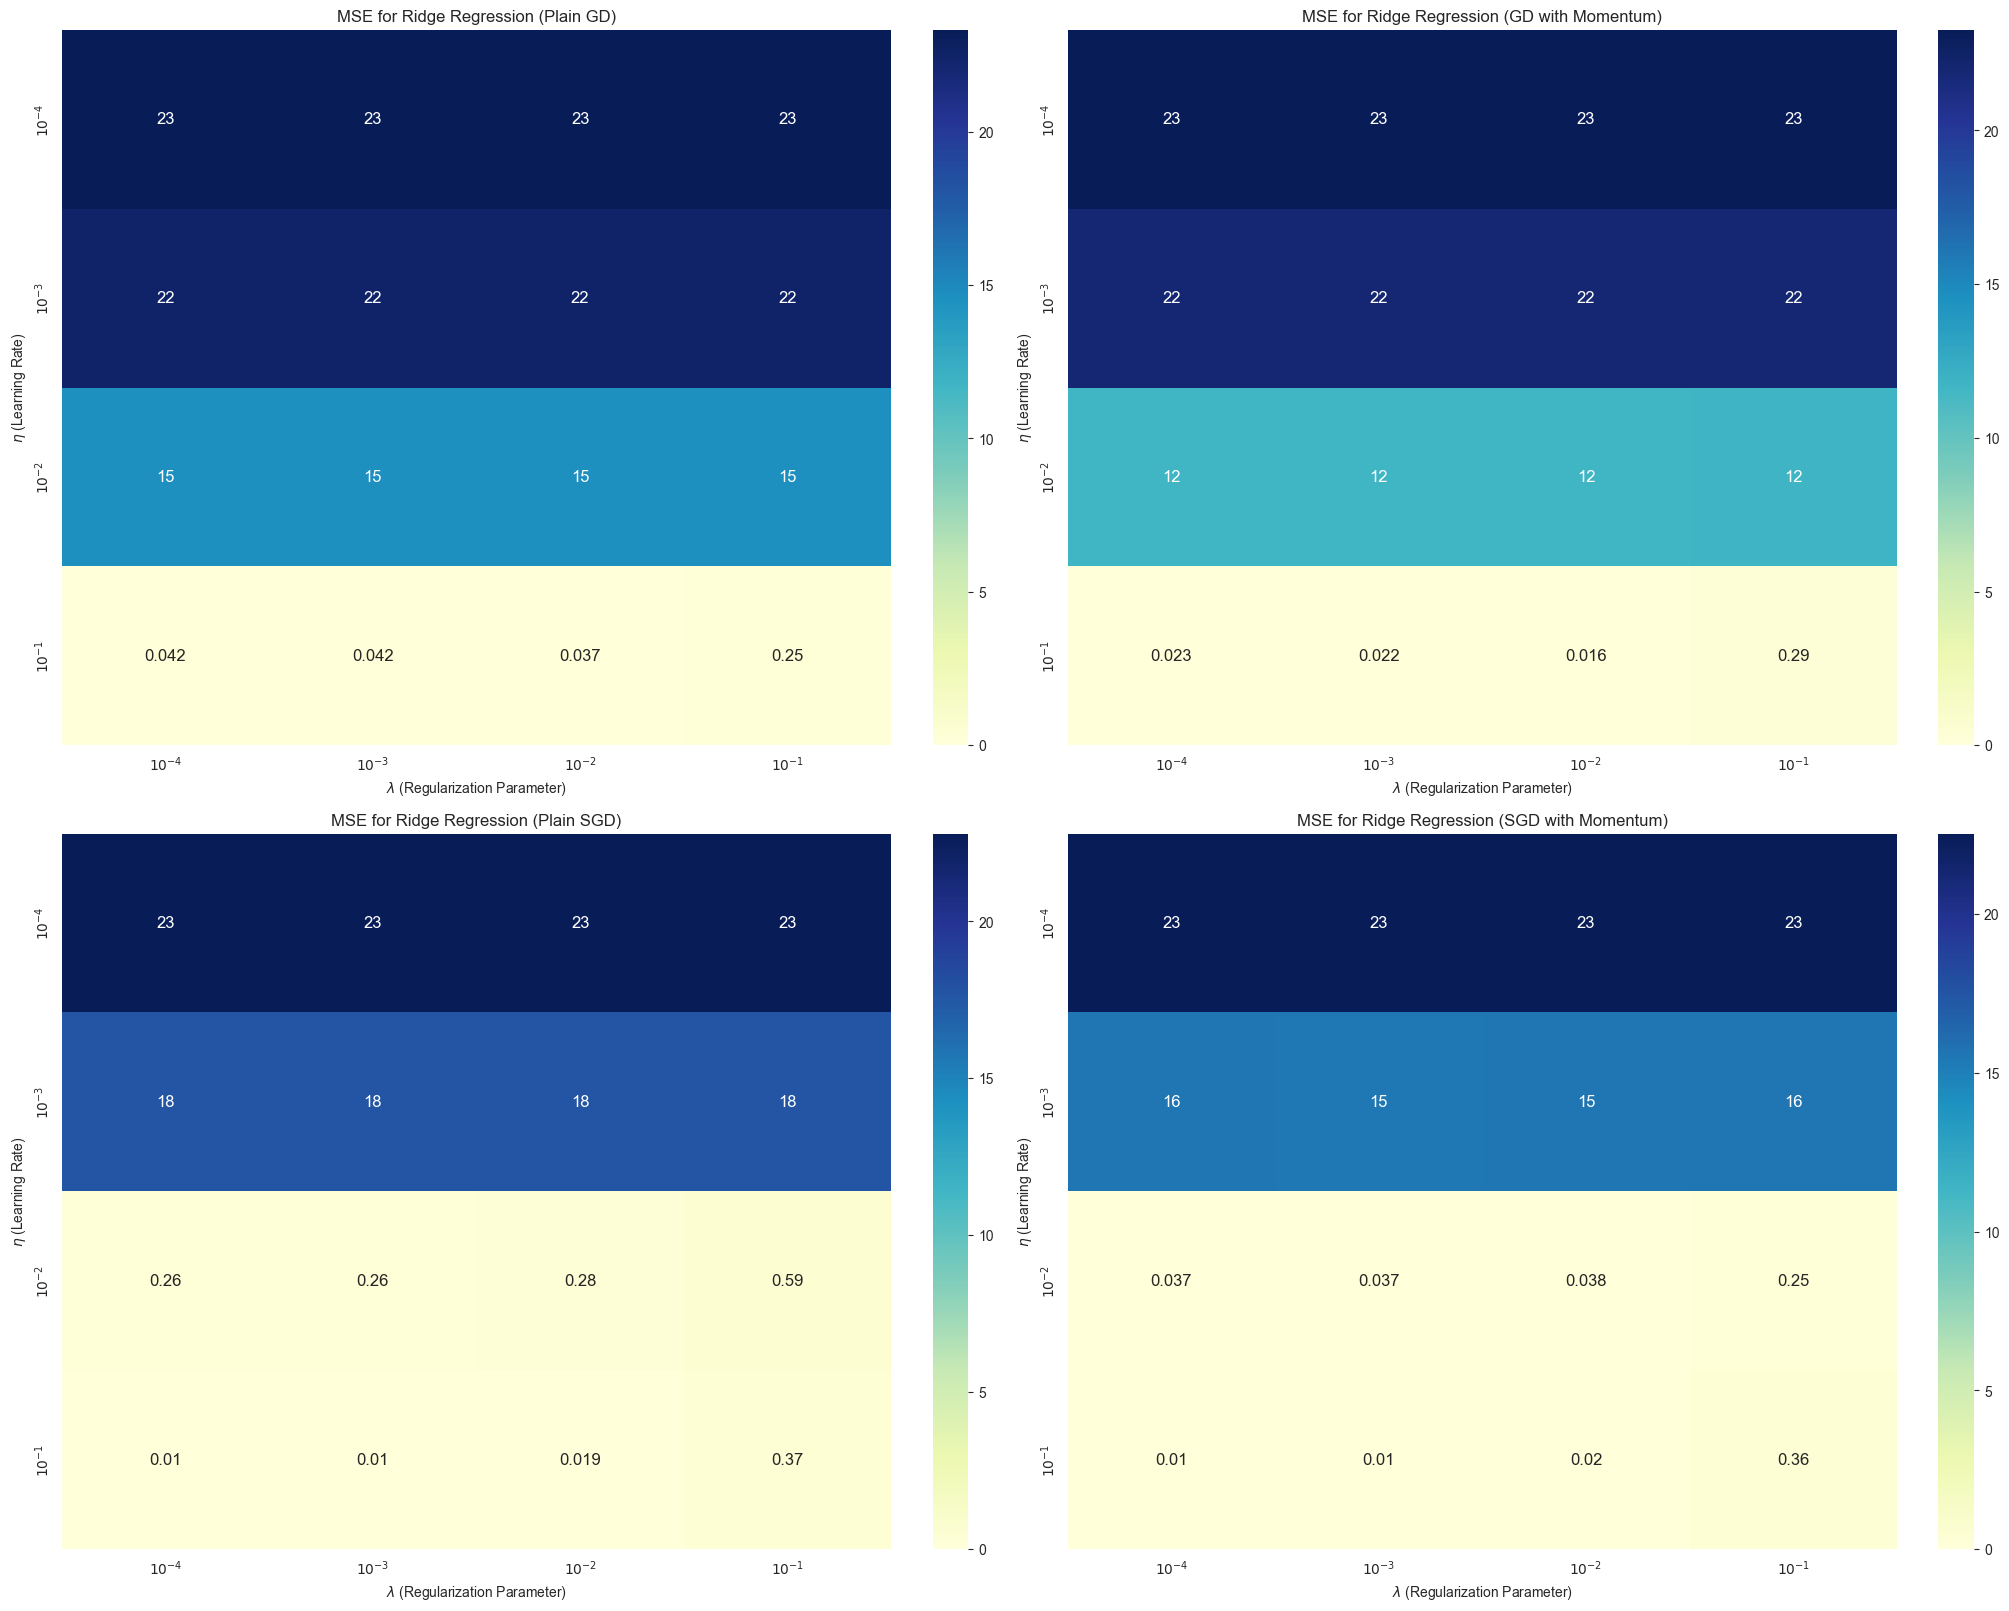

In [20]:
def plot_Ridge_heatmap_comparison(X, y, beta, learning_rates, lambdas, Niterations, n_epochs, batch_size, delta_momentum):
    # Initialize arrays to store MSE values for each method
    mse_plain_GD = np.zeros((len(learning_rates), len(lambdas)))
    mse_GD_momentum = np.zeros((len(learning_rates), len(lambdas)))
    mse_plain_SGD = np.zeros((len(learning_rates), len(lambdas)))
    mse_SGD_momentum = np.zeros((len(learning_rates), len(lambdas)))

    # Calculate MSE for each combination of learning rate and lambda
    for i, eta in enumerate(learning_rates):
        for j, lmbda in enumerate(lambdas):
            beta_init = beta.copy()
            beta_plain_GD = AdagradGD(X, y, beta_init, n=len(y), eta=eta, lmbda=lmbda, Niterations=Niterations, ridge=True, momentum=False)
            mse_plain_GD[i, j] = MSE(y, X @ beta_plain_GD)

            beta_init = beta.copy()
            beta_GD_momentum = AdagradGD(X, y, beta_init, n=len(y), eta=eta, lmbda=lmbda, Niterations=Niterations, ridge=True, momentum=True, delta_momentum=delta_momentum)
            mse_GD_momentum[i, j] = MSE(y, X @ beta_GD_momentum)

            beta_init = beta.copy()
            beta_plain_SGD = Adagrad_SGD(X, y, beta_init, n=len(y), n_epochs=n_epochs, batch_size=batch_size, eta=eta, ridge=True, lmbda=lmbda, momentum=False)
            mse_plain_SGD[i, j] = MSE(y, X @ beta_plain_SGD)

            beta_init = beta.copy()
            beta_SGD_momentum = Adagrad_SGD(X, y, beta_init, n=len(y), n_epochs=n_epochs, batch_size=batch_size, eta=eta, ridge=True, lmbda=lmbda, momentum=True, delta_momentum=delta_momentum)
            mse_SGD_momentum[i, j] = MSE(y, X @ beta_SGD_momentum)

    # Set up tick labels
    xticks = [f"$10^{{{int(np.log10(val))}}}$" for val in lambdas]
    yticks = [f"$10^{{{int(np.log10(val))}}}$" for val in learning_rates]

    # Plot side-by-side heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(20, 16), constrained_layout=True)

    sns.heatmap(mse_plain_GD, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12}, ax=axes[0, 0])
    axes[0, 0].set_xlabel("$\lambda$ (Regularization Parameter)")
    axes[0, 0].set_ylabel("$\eta$ (Learning Rate)")
    axes[0, 0].set_title("MSE for Ridge Regression (Plain GD)")

    sns.heatmap(mse_GD_momentum, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12}, ax=axes[0, 1])
    axes[0, 1].set_xlabel("$\lambda$ (Regularization Parameter)")
    axes[0, 1].set_ylabel("$\eta$ (Learning Rate)")
    axes[0, 1].set_title("MSE for Ridge Regression (GD with Momentum)")

    sns.heatmap(mse_plain_SGD, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12}, ax=axes[1, 0])
    axes[1, 0].set_xlabel("$\lambda$ (Regularization Parameter)")
    axes[1, 0].set_ylabel("$\eta$ (Learning Rate)")
    axes[1, 0].set_title("MSE for Ridge Regression (Plain SGD)")

    sns.heatmap(mse_SGD_momentum, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12}, ax=axes[1, 1])
    axes[1, 1].set_xlabel("$\lambda$ (Regularization Parameter)")
    axes[1, 1].set_ylabel("$\eta$ (Learning Rate)")
    axes[1, 1].set_title("MSE for Ridge Regression (SGD with Momentum)")

    plt.show()

plot_Ridge_heatmap_comparison(X, y, beta, learning_rates, lambdas, Niterations, n_epochs, batch_size, delta_momentum)

#### Discussion:

In both we can see that momentum improves the convergence in both OLS and Ridge regression. We can also see that smaller batch sized results in faster convergence due to more frequent updatees. The difference is biggest in the Ridge regression.

### Step 5: RMSprop and Adam 
Add RMSprop and Adam to your library of methods for tuning the learning rate.

In [21]:
#Taken from week 39 - RMSprop for adaptive learning rate with Stochastic Gradient Descent
#RMSprop_SGD with mini batches and momentum
def RMSprop_SGD(X, y, beta, n = 100,  n_epochs=100, batch_size=5, eta=0.01, ridge = False,lmbda=0.01, rho=0.99, delta=1e-8):
    M = batch_size
    m = int(n / M)
    Giter=0.0

    for epoch in range(n_epochs):
        for i in range(m):
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]

            if ridge:
                gradients = gradientRidge(xi, yi, beta, n, lmbda)
            else:
                gradients = gradientOLS(xi, yi, beta, n)

            Giter = rho * Giter + (1 - rho) * gradients**2
            update = eta * gradients / (delta + np.sqrt(Giter))
            beta -= update

    return beta


In [22]:
#Taken from week 39 -> And finally ADAM
def Adam_SGD(X, y, beta, n= 100,  n_epochs=100, batch_size=5, eta=0.01, ridge = False, lmbda = 0.01,  beta1=0.9, beta2=0.999, delta=1e-8):
    M = batch_size
    m = int(n / M)
    first_moment = 0.0
    second_moment = 0.0
    iter=0
    for epoch in range(n_epochs):
        iter += 1
        for i in range(m):
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]

            if ridge:
                gradients = gradientRidge(xi, yi, beta, n, lmbda)
            else:
                gradients = gradientOLS(xi, yi, beta, n)

            first_moment = beta1 * first_moment + (1 - beta1) * gradients
            second_moment = beta2 * second_moment + (1 - beta2) * gradients**2
            first_unbias = first_moment / (1 - beta1**iter)
            second_unbias = second_moment / (1 - beta2**iter)
            update = eta * first_unbias / (np.sqrt(second_unbias) + delta)
            beta -= update

    return beta


## Comparing the results

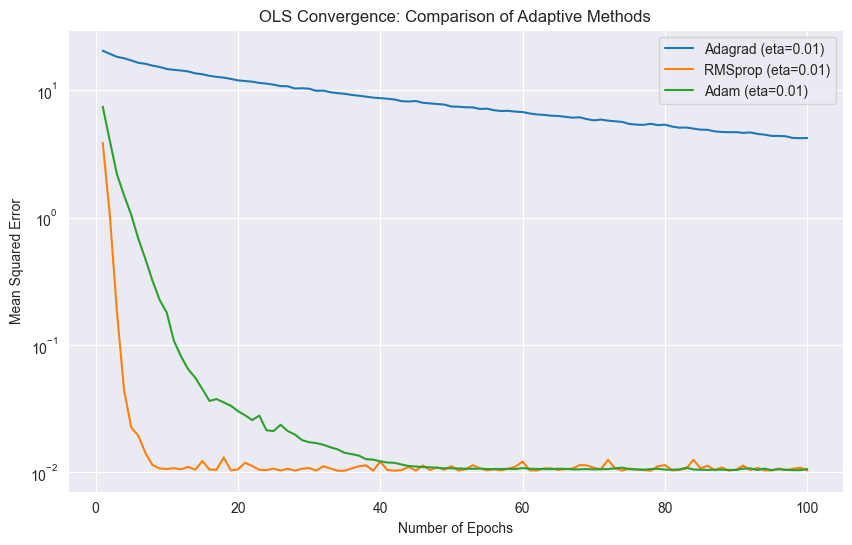

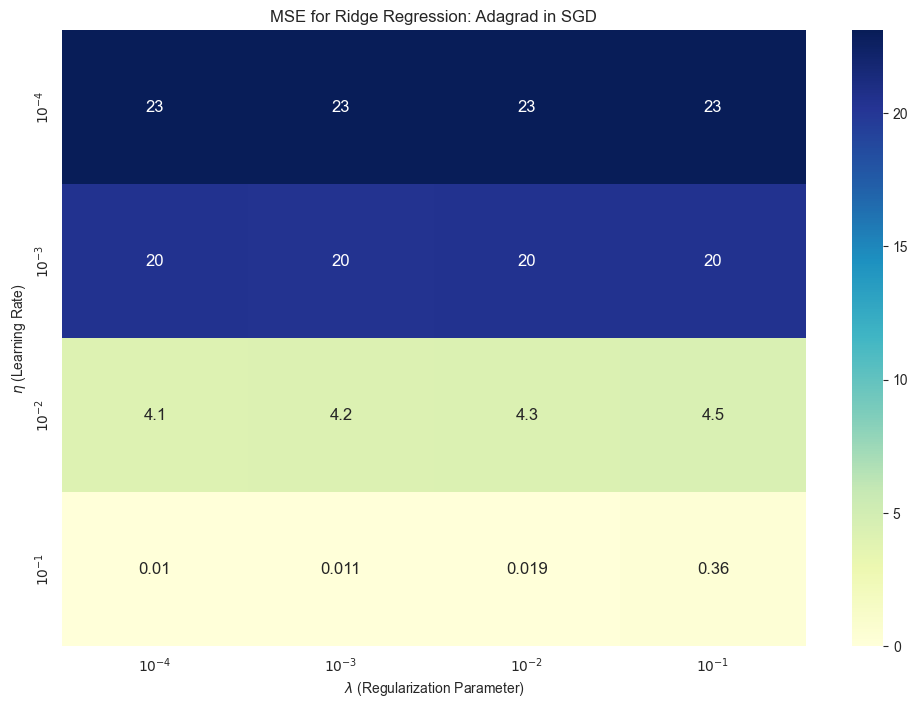

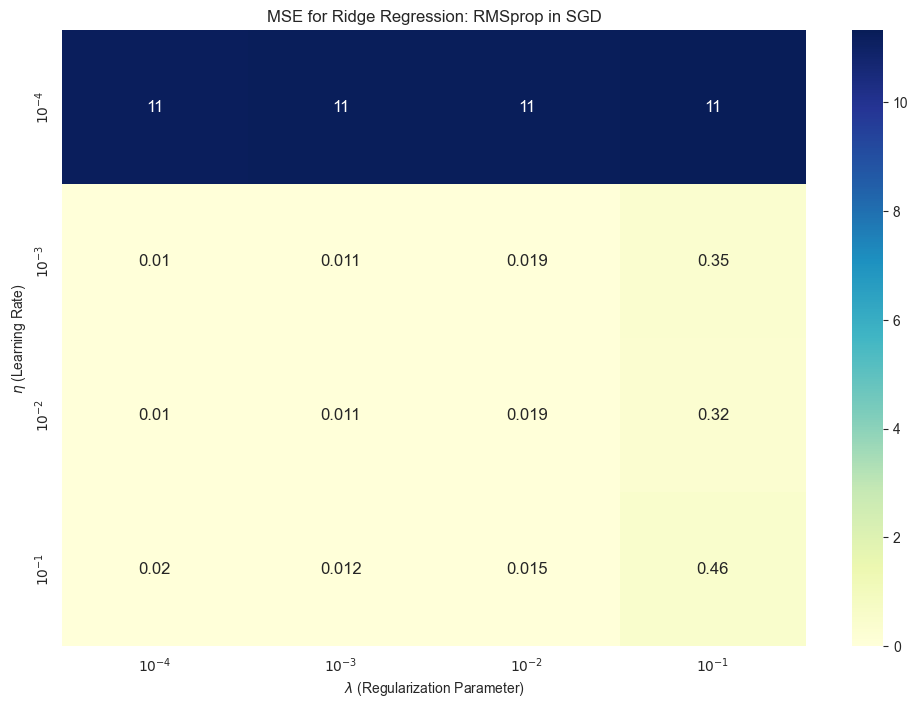

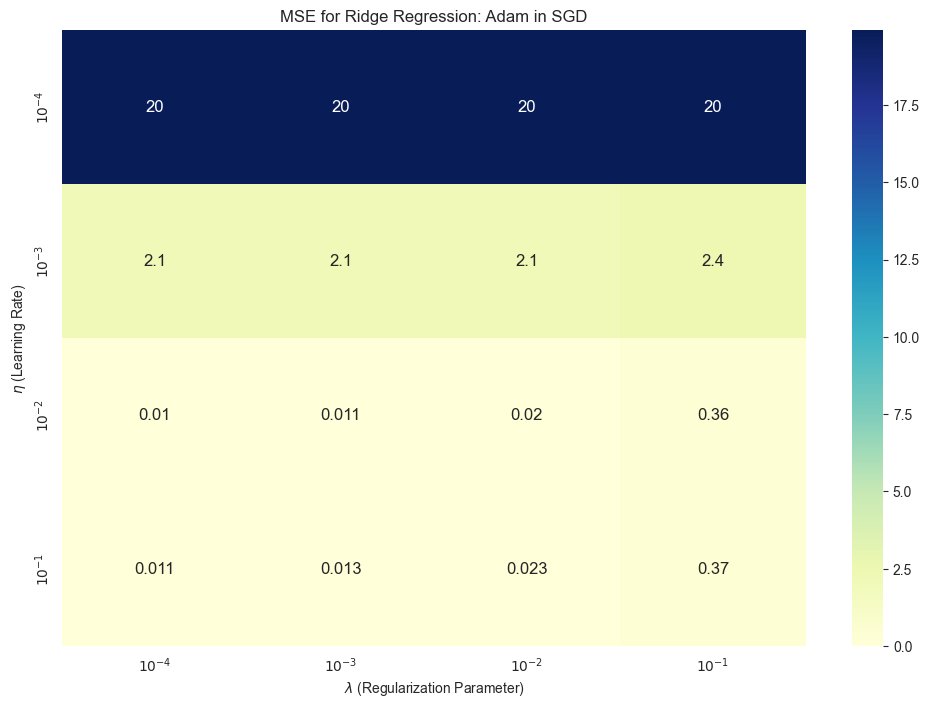

In [23]:
# Line Plot for OLS (without Ridge)
def plot_OLS_convergence_adaptive_methods(X, y, beta, eta, n_epochs=50, batch_size=5):
    methods = {
        "Adagrad": Adagrad_SGD,
        "RMSprop": RMSprop_SGD,
        "Adam": Adam_SGD
    }
    mse_values = {method: [] for method in methods.keys()}

    for method_name, method_func in methods.items():
        beta_copy = beta.copy()
        for epoch in range(1, n_epochs + 1):
            beta_result = method_func(X, y, beta_copy.copy(), n=len(y), n_epochs=epoch, batch_size=batch_size, eta=eta)
            mse_values[method_name].append(MSE(y, X @ beta_result))

    # Plotting
    plt.figure(figsize=(10, 6))
    for method_name, mse in mse_values.items():
        plt.plot(range(1, n_epochs + 1), mse, label=f'{method_name} (eta={eta})')

    plt.xlabel('Number of Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('OLS Convergence: Comparison of Adaptive Methods')
    plt.legend()
    plt.yscale("log")  # Log scale for better visualization
    plt.show()

# Heatmap for Ridge Regression
def plot_Ridge_heatmap_adaptive_methods(X, y, beta, learning_rates, lambdas, n_epochs=50, batch_size=5):
    methods = {
        "Adagrad": Adagrad_SGD,
        "RMSprop": RMSprop_SGD,
        "Adam": Adam_SGD
    }

    for method_name, method_func in methods.items():
        mse_values = np.zeros((len(learning_rates), len(lambdas)))

        for i, eta in enumerate(learning_rates):
            for j, lmbda in enumerate(lambdas):
                beta_result = method_func(X, y, beta.copy(), n=len(y), n_epochs=n_epochs, batch_size=batch_size, eta=eta, ridge=True, lmbda=lmbda)
                mse_values[i, j] = MSE(y, X @ beta_result)

        # Set up tick labels for heatmap
        xticks = [f"$10^{{{int(np.log10(val))}}}$" for val in lambdas]
        yticks = [f"$10^{{{int(np.log10(val))}}}$" for val in learning_rates]

        # Plotting the heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(mse_values, annot=True, cmap="YlGnBu", yticklabels=yticks, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12})
        plt.xlabel("$\lambda$ (Regularization Parameter)")
        plt.ylabel("$\eta$ (Learning Rate)")
        plt.title(f"MSE for Ridge Regression: {method_name} in SGD")
        plt.show()

# Example usage
np.random.seed(2014)
n = 400
x = np.random.rand(n, 1)  # Input data
y = 2 + 3 * x + 4 * x**2 + 0.1 * np.random.randn(n, 1)  # Target with noise
p = 2  # Polynomial degree
X = np.c_[np.ones((n, 1)), x, x**2]  # Design matrix for second-degree polynomial
beta = np.random.randn(p + 1, 1)  # Initial parameter values

# Parameters
eta = 0.01
n_epochs = 100
batch_size = 5
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
lambdas = [1e-4, 1e-3, 1e-2, 1e-1]

# Plot OLS convergence
plot_OLS_convergence_adaptive_methods(X, y, beta, eta, n_epochs=n_epochs, batch_size=batch_size)

# Plot Ridge heatmap for different learning rates and lambdas
plot_Ridge_heatmap_adaptive_methods(X, y, beta, learning_rates, lambdas, n_epochs=n_epochs, batch_size=batch_size)

#### Discussion:
With these parameters, in the plot we can see that RMSprop is the most stable and converges the fastest. Adam is the second best, and Adagrad is the slowest to converge.

The regulazation of ridge also helps the convergence in all the methods.




### OLS Convergence Plot (Line Graph)
In this plot, you’re comparing Adagrad, RMSprop, and Adam for **OLS regression** over epochs.

- **Observations**:
  - **Adam** and **RMSprop** converge faster to a lower MSE than Adagrad.
  - **Adagrad** has a higher and slower convergence path, and it does not reach as low of an MSE as RMSprop or Adam.

- **Does it Make Sense?**
  - Yes, this behavior is expected:
    - **Adagrad** accumulates squared gradients over time, which can make its learning rate decay too quickly, particularly when training for many epochs. This often leads to Adagrad "stalling" early on and not reaching the lowest possible MSE.
    - **RMSprop** and **Adam** use mechanisms (e.g., RMSprop’s exponential decay and Adam’s momentum with bias correction) that prevent their learning rates from decaying too quickly, allowing them to converge more effectively in later epochs.

### Ridge Regression Heatmaps
Each heatmap shows the MSE for different combinations of learning rates and regularization parameters \( \lambda \) for Adagrad, RMSprop, and Adam in **Ridge regression**.

1. **Adagrad Heatmap**:
   - MSE is significantly higher for larger learning rates (e.g., \(10^{-3}\) and \(10^{-2}\)) compared to RMSprop and Adam.
   - This could be due to Adagrad’s tendency to decay the learning rate too aggressively, causing it to converge prematurely and get "stuck" at suboptimal MSE levels, especially when \( \lambda \) is high.
   
2. **RMSprop and Adam Heatmaps**:
   - Both RMSprop and Adam show lower MSE values for higher learning rates (\(10^{-2}\)) and moderate \( \lambda \) values.
   - They are less affected by learning rate decay issues because their update mechanisms adapt without excessive reduction in learning rate over time.
   - The MSE is more stable across different \( \lambda \) values, reflecting better convergence.

- **Why is Adagrad High?**
   - **Explanation**: Adagrad’s accumulation of squared gradients causes the effective learning rate to shrink rapidly, especially in high-dimensional or complex models. This effect is more pronounced when training with larger learning rates over many epochs, as seen in your heatmap, where Adagrad’s MSE does not improve as much as with RMSprop or Adam.
   - **Solution**: Using Adagrad with lower initial learning rates or fewer epochs might help, but in general, RMSprop or Adam are better suited for this task due to their more balanced learning rate adjustments.

### Summary
- The plots align with expected behavior, showing Adagrad struggling with higher MSE due to fast-decaying learning rates, while RMSprop and Adam handle learning rate adjustments more effectively, achieving lower MSE.
